# 0. Setup

In [ ]:
! rm -rf /content/sample_data
! mkdir saved_models

In [ ]:
!pip install 'ray[tune]'

## Imports

In [9]:
import os
import time
import random
import gc
import multiprocessing
from collections import Counter

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision
from torchvision import datasets, models, transforms

import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader, Subset, SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path
from google.colab import drive
from shutil import copyfile

import pandas as pd
from pandas import DataFrame
import seaborn as sns

from functools import partial

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

## Setup GPU

In [10]:
use_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
if device.type == 'cuda':
  print('CUDA is available. Training on GPU')
else:
  print('CUDA is not available. Training on CPU')

CUDA is available. Training on GPU


# 1. Download Data

## Download Data


### Download Data from Google Drive

In [11]:
def download_data(train=True):
    """ Function to download data from google drive
        Args:
            train: specifies whether to download train or test data
    """
    gdrive_path = Path('./drive')
    gdrive_dir = 'aps360'

    # mount your google drive to colab 
    drive.mount(gdrive_path.as_posix())
    gdrive_path  /= 'My Drive'

    if train:
        file_name = 'aps360_project_db_train.zip'
    else:
        file_name = 'aps360_project_db_test.zip'

    # get file path
    data_path = gdrive_path / gdrive_dir / file_name

    # copy dependencies from gdrive into colab 
    os.makedirs('./rawdata', exist_ok=True)
    copyfile(data_path, "./rawdata/" + file_name)

    # unmount gdrive
    drive.flush_and_unmount()

def unzip_data(train=True):
    """ Function to unzip dataset
        Args:
            train: specifies whether to download train or test data
    """
    if train:
        ! unzip /content/rawdata/aps360_project_db_train.zip
        ! rm -rf /content/rawdata/
    else:
        ! unzip /content/rawdata/aps360_project_db_test.zip
        ! rm -rf /content/rawdata/

def delete_data(train=True):
    """ Function to delete dataset
        Args:
            train: specifies whether to download train or test data
    """
    if train:
        ! rm -rf /content/TRAIN
    else:
        ! rm -rf /content/TEST

### Download training data  

.    
└── 📁 TRAIN    
  ├── 📁 O  
  └── 📁 R   

In [12]:
train_data_dir = "/content/TRAIN"

In [13]:
%%capture
download_data(train=True)
unzip_data(train=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g4nk4Ertx7x95khcbmdAj70TXsTRc_F1FMvi9S_vsLEwDNN3EoUsc0


In [6]:
# delete_data(train=True)

### Download test data  

.    
└── 📁 TEST    
  ├── 📁 O  
  └── 📁 R   

In [63]:
test_data_dir = "/content/TEST"

In [64]:
%%capture
download_data(train=False)
unzip_data(train=False)

In [65]:
# delete_data(train=False)

# 2. Split Data

In [19]:
# Source: https://github.com/ufoym/imbalanced-dataset-sampler
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        if self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        else:
            raise NotImplementedError
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [20]:
def create_dataset(train=True):
    """ Load data from file system and create a dataset
    Args:
        train: choose between training set and test set
    Returns:
        dataset 
    """
    # convert images to (224 x 224)
    data_transform = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ColorJitter(brightness=0.1, hue=0.05, saturation=0.01),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(35),
                                        transforms.ToTensor()])

    # load dataset
    if train:
        return datasets.ImageFolder(train_data_dir, transform=data_transform)  
    else:
        return datasets.ImageFolder(test_data_dir, transform=data_transform)
  
def split_data(dataset, train=True, train_ratio=0.7, batch_size=25, 
                                                    seed=1000, shuffle=True):
    """ Load data from dataset and split it into train/valid/test sets
    Args:
        dataset: dataset containing all data
        train: determines if dataset is for the train or the test set. 
                If it's the test set, don't split
        train_ratio: percentage of data to go into training set
        batch_size: batch size for dataloader
        seed: random seed
        shuffle: flag on whether the shuffle original dataset or not
    Returns:
        train_loader: training dataloader
        valid_loader: validation dataloader
        test_loader: test dataloader    
    """
    # number of examples in dataset
    num_data = len(dataset)

    # shuffle data
    if shuffle:
        torch.manual_seed(seed)
        indices = torch.randperm(num_data)
    else:
        indices = torch.arange(num_data)

    # dataloader parameters
    num_workers = multiprocessing.cpu_count()
    prefetch_factor = 8
    pin_mem = False
    if torch.cuda.is_available():
        pin_mem = True

    if train:
        # calculate indices to split data at
        split = int(np.floor(train_ratio * num_data))

        # train/valid split
        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = Subset(dataset, train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        # create Data loaders
        train_loader = DataLoader(dataset, 
                                  batch_size=batch_size, 
                                  sampler=ImbalancedDatasetSampler(train_sampler), 
                                  num_workers=num_workers, 
                                  pin_memory=pin_mem,
                                  prefetch_factor=prefetch_factor)
        
        valid_loader = DataLoader(dataset, 
                                  batch_size=batch_size, 
                                  sampler=valid_sampler, 
                                  num_workers=num_workers, 
                                  pin_memory=pin_mem,
                                  prefetch_factor=prefetch_factor)
        
        return train_loader, valid_loader

    else:
        # all data placed in test set
        test_idx = indices
        test_sampler = SubsetRandomSampler(test_idx)

        test_loader = DataLoader(dataset, 
                                 batch_size=batch_size, 
                                 sampler=test_sampler, 
                                 num_workers=num_workers, 
                                 pin_memory=pin_mem,
                                 prefetch_factor=prefetch_factor)
        
        return test_loader

In [21]:
# create train dataset
train_dataset = create_dataset(train=True)

# 3. Visualize Data

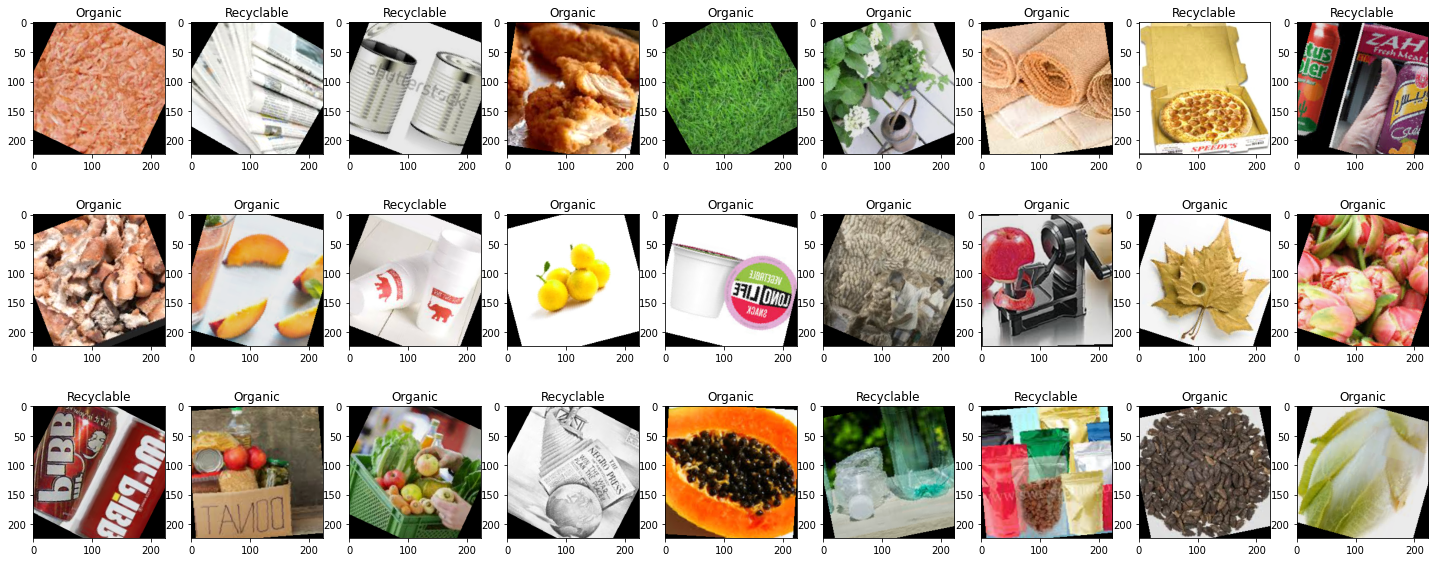

In [ ]:
test_dataset = create_dataset(train=False)

classes = ['Organic', 'Recyclable']
batch_size = 1
num_sample_batches = 27
num_cols = 9
num_rows = num_sample_batches / num_cols

train_iter = iter(train_loader)
fig = plt.figure(figsize=(25, 10))

for i in range(num_sample_batches):
    for j in range(batch_size):
      imgs, labels = train_iter.next()
      ax = fig.add_subplot(num_rows, num_cols, i + 1)
      plt.imshow(np.transpose(imgs[j], (1, 2, 0)))
      ax.set_title(classes[labels[j]])

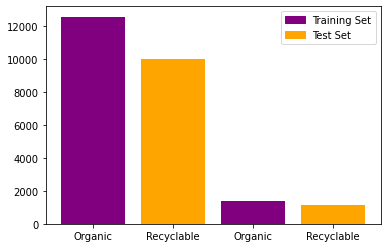

In [ ]:
# print(dict(Counter(train_dataset.targets)))
# print(dict(Counter(test_dataset.targets)))

# Bar graph of number organic and recyclable examples
train_classes_dict = dict(Counter(train_dataset.targets))
test_classes_dict = dict(Counter(test_dataset.targets))
height = [train_classes_dict.get(0), train_classes_dict.get(1), test_classes_dict.get(0), test_classes_dict.get(1)]
bars = ('Organic', 'Recyclable', 'Organic', 'Recyclable')
x_pos = np.arange(len(bars))

plt.bar(x_pos, height, color=['purple', 'orange'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

# Add a legend
colors = {'Training Set':'purple', 'Test Set':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

# 4. Define Model

In [22]:
def get_num_params(net):
    """determine the size of the model
    Args:
        net: machine learning model
    Returns:
        size of model
    """
    return sum(p.numel() for p in net.parameters())

In [23]:
# Base CNN model
class CNN(nn.Module):
    def __init__(self, nin: int, nout: int, k=5, s=1):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(nin, nout, kernel_size=k, stride=s)

    def forward(self, x):
        x = F.relu(self.conv(x))
        return x 

# First iteration of Waste Classifier
class WasteClassifier(nn.Module):
    def __init__(self, get_size=False):
        super(WasteClassifier, self).__init__()
        self.get_size = get_size
        self.conv = nn.Sequential(
            CNN(nin=3, nout=10),
            nn.MaxPool2d(2, 2),
            CNN(nin=10, nout=30),
            nn.MaxPool2d(2, 2))
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(84270, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def forward(self, x):
        x = self.conv(x) 
        x = self.flatten(x)
        if self.get_size:
            print("flattened layer size: ", x.size())
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x 

In [24]:
print(f"Number of parameters in model: {get_num_params(WasteClassifier())}")

Number of parameters in model: 5401699


# 5. Training Code

In [77]:
def save_model(model, filename=""):
    """ Save a model for inference for later use
    Args:
        model: trained machine learning model to be saved
        filename: name of file
    """
    PATH = ""
    if filename == "":
        PATH = "/content/saved_models/" + str(random.randint(1,100000))
    else:
        PATH = "/content/saved_models/" + filename
    torch.save(model.state_dict(), PATH)

def load_model(model, PATH, device):
    """ Load a previously saved model
    Args:
        model: model with same architecture as the one you're trying to load
        PATH: file path to load from
        device: device (cpu or gpu) to load the model into
    """
    model.load_state_dict(torch.load(PATH, map_location=device))

def upload_model_to_drive(file_name):
    """ Upload a saved model to google drive
    Args:
        file_name: file name of model to be saved
    """
    gdrive_path = Path('./drive')
    gdrive_dir = 'aps360'

    # mount your google drive to colab 
    drive.mount(gdrive_path.as_posix())
    gdrive_path  /= 'My Drive'

    # get file path in google drive
    data_path = gdrive_path / gdrive_dir / file_name

    # append filepath to filename
    file_name = "/content/saved_models/" + file_name

    # copy to drive
    copyfile(file_name, data_path)

    # unmount gdrive
    drive.flush_and_unmount()

def download_model_from_drive(file_name):
    """ Download a model from google drive to current session
    Args:
        file_name: name of file
    """
    gdrive_path = Path('./drive')
    gdrive_dir = 'aps360'

    # mount your google drive to colab 
    drive.mount(gdrive_path.as_posix())
    gdrive_path  /= 'MyDrive'

    # get file path
    data_path = gdrive_path / gdrive_dir / file_name

    # copy from drive
    PATH = "/content/saved_models/" + file_name
    copyfile(data_path, PATH)

    # unmount gdrive
    drive.flush_and_unmount()

def load_model_from_drive(model, device, file_name):
    """ Directly load a pytorch model saved in google drive
    Args:
        model: empty pytorch model with same architecure as the one being loaded
        device: location to load model (cpu or gpu)
        file_name: name of file where model is saved to
    """
    gdrive_path = Path('./drive')
    gdrive_dir = 'aps360'

    # mount your google drive to colab 
    drive.mount(gdrive_path.as_posix())
    gdrive_path  /= 'MyDrive'

    # get file path
    data_path = gdrive_path / gdrive_dir / file_name

    # load model from drive
    model.load_state_dict(torch.load(data_path, map_location=device))

    # unmount gdrive
    drive.flush_and_unmount()

In [67]:
def get_optimizer(model, config):
    """ Get an optimizer for your model
    Args:
        model: machine learning model
        params: dictionary of hyperparameters for model
    Returns:
        optimizer for model based on params
    """

    if config['optim'] == 'RMS':
        return optim.RMSprop(model.parameters(),
                            lr=config["lr"],
                            momentum=config["mm"],
                            weight_decay=config["wd"])
    elif config['optim'] == 'ADAM':
        return optim.Adam(model.parameters(), 
                            lr=config["lr"],
                            weight_decay=config["wd"])
    else:
        return optim.SGD(model.parameters(), 
                            lr=config["lr"],
                            momentum=config["mm"],
                            weight_decay=config["wd"])
        
@torch.no_grad()
def evaluate(model, val_loader, criterion):
    """ Compute accuracy and loss of the model on the validation set
     Args:
        model: machine learning model
        val_loader: dataloader for the validation set
        criterion: loss function
     Returns:
         acc: the accuracy of the model
         loss: the loss of the model
     """
    total_loss = 0.0
    total_acc = 0.0
    total_examples = 0
    for i, (imgs, labels) in enumerate(val_loader, 0):
        # use GPU if available
        imgs = imgs.to(device)
        labels = labels.to(device)

        # get predictions
        out = model(imgs)
        loss = criterion(out, labels.float())

        # converts to 0 (organic) or 1 (recyclable) and compares with label
        pred = (out >= 0.0).squeeze().long() == labels 

        # calculate accuracy and loss
        total_acc += sum(pred).item()
        total_loss += loss.item()
        total_examples += len(labels)    

    acc = float(total_acc) / total_examples   
    loss = float(total_loss) / (i+1)   
    return acc, loss

@torch.no_grad()
def plot_confusion_matrix(model, dataloader):
    confusion_matrix = np.zeros((2, 2))
    
    for (imgs, labels) in dataloader:
        # use GPU if available
        imgs = imgs.to(device)
        labels = labels.to(device)

        # get predictions
        out = model(imgs)
        pred = (out >= 0.0).squeeze().long()
        for p, l in zip(pred, labels):
            confusion_matrix[p.long(), l.long()] += 1

    # plot heatmap
    plt.figure(figsize=(9,6))
    classes = ['organic', 'recyclable']
    df = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
    heatmap = sns.heatmap(df, annot=True, fmt="d")

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0)
    plt.xlabel('Real label')
    plt.ylabel('Predicted label')

    # calculate accuracy
    TP = confusion_matrix[0][0]
    TN = confusion_matrix[1][1]
    acc = (TP + TN) / confusion_matrix.sum()
    print(f"Accuracy: {acc:.8f}")

def plot_trials(dfs):
    """ Plot results of each trial in raytune
        dfs: raytune trial_dataframes
    """
    fig, ax = plt.subplots(nrows=1, ncols=1)  
    for d in dfs.values():
        acc = d.accuracy
        ax.plot(np.arange(1, len(acc)+1), acc, marker='o', label=d['trial_id'][0])
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy per trial")
    ax.legend()
    plt.show()

def train(config, num_epochs=10, device=None, checkpoint_dir=None):
    """ Train the model and plot the learning curves
     Args:
        config: dictionary of hyperparameters to tune
        device: torch.device object. Either 'cpu' or 'cuda'
     """

    # define model
    model = WasteClassifier()
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()  
    optimizer = get_optimizer(model, config)
    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    # define dataloader
    train_loader, val_loader = split_data(train_dataset, 
                                    train=True, 
                                    batch_size=config["batch_size"])
   
    train_acc, train_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    val_acc, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_examples = 0

        for i, (imgs, labels) in enumerate(train_loader):
            # use GPU if available
            imgs = imgs.to(device)
            labels = labels.to(device)

            # zero the gradients
            optimizer.zero_grad()

            # training
            out = model(imgs)
            loss = criterion(out, labels.float())
            loss.backward()
            optimizer.step()

            # converts to 0 (organic) or 1 (recyclable) and compares with label
            pred = (out >= 0.0).squeeze().long() == labels 

            # calculate accuracy and loss
            total_train_acc += sum(pred).item()
            total_train_loss += loss.item()
            total_examples += len(labels)

        train_acc[epoch] = float(total_train_acc) / total_examples   
        train_loss[epoch] = float(total_train_loss) / (i+1)   
        val_acc[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        # report results to raytune
        tune.report(loss=val_loss[epoch], accuracy=val_acc[epoch])

    return

# 6. Experimentation

In [ ]:
"""
Save a model to local file system
"""
save_model(model)

In [ ]:
"""
Load a saved model from local file system
"""
new_model = WasteClassifier()
load_model(new_model, "/content/saved_models/58870", device)
new_model.to(device)

In [ ]:
"""
Upload a saved model from local file system to Google Drive 
"""
PATH = "/content/saved_models/58870"
upload_model_to_drive(PATH, file_name="58870")

In [ ]:
"""
Download a saved model from Google Drive to local file system
"""
download_model_from_drive("58870")

In [ ]:
"""
Load a saved model from Google Drive
"""
new_model = WasteClassifier()
load_model_from_drive(new_model, device, "58870")
new_model.to(device)

# 8. Ray Tune

In [60]:
def run_test(num_samples=2, max_num_epochs=2, gpus_per_trial=1):
    config = {
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([16, 32, 64]),
        "optim": tune.choice(['ADAM', 'SGD']),
        "mm": tune.choice([0.0]),
        "wd": tune.choice([0, 5e-3]) 
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    result = tune.run(
        partial(train, num_epochs=max_num_epochs, device=device),
        resources_per_trial={"cpu": 1, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print(f'Best trial config: {best_trial.config}')
    print(f'Best trial final validation loss: {best_trial.last_result["loss"]}')
    print(f'Best trial final validation accuracy: {best_trial.last_result["accuracy"]}')

    best_trained_model = WasteClassifier()
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    dfs = result.trial_dataframes
    return dfs, best_trained_model

In [61]:
dfs, best_trained_model = run_test()

2021-03-24 00:10:34,117	WARNING experiment.py:292 -- No name detected on trainable. Using DEFAULT.
2021-03-24 00:10:34,118	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Memory usage on this node: 1.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: None
Resources requested: 1/2 CPUs, 1/1 GPUs, 0.0/7.32 GiB heap, 0.0/2.49 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2021-03-24_00-10-34
Number of trials: 1/2 (1 RUNNING)
+---------------------+----------+-------+--------------+------------+------+---------+-------+
| Trial name          | status   | loc   |   batch_size |         lr |   mm | optim   |    wd |
|---------------------+----------+-------+--------------+------------+------+---------+-------|
| DEFAULT_5a543_00000 | RUNNING  |       |           32 | 0.00185324 |    0 | ADAM    | 0.005 |
+---------------------+----------+-------+--------------+------------+------+---------+-------+


Result for DEFAULT_5a543_00000:
  accuracy: 0.7831610044313146
  date: 2021-03-24_00-12-59
  done: false
  experiment_id: 0525c89a0cff4fe2b1e6f602709dad78
  hostname: cc4c31928e52


2021-03-24 00:17:44,418	INFO tune.py:450 -- Total run time: 430.30 seconds (430.25 seconds for the tuning loop).


Result for DEFAULT_5a543_00001:
  accuracy: 0.4465288035450517
  date: 2021-03-24_00-17-44
  done: true
  experiment_id: 96213ac6af0141058e071b25e920da09
  hostname: cc4c31928e52
  iterations_since_restore: 1
  loss: 0.6890093228727017
  node_ip: 172.28.0.2
  pid: 1997
  should_checkpoint: true
  time_since_restore: 140.64449071884155
  time_this_iter_s: 140.64449071884155
  time_total_s: 140.64449071884155
  timestamp: 1616545064
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a543_00001
  
== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 2.000: None | Iter 1.000: -0.5810653300920747
Resources requested: 1/2 CPUs, 1/1 GPUs, 0.0/7.32 GiB heap, 0.0/2.49 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2021-03-24_00-10-34
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+---------------------+------------+-----------------+--------------+-------------+------+---------+-------+----------

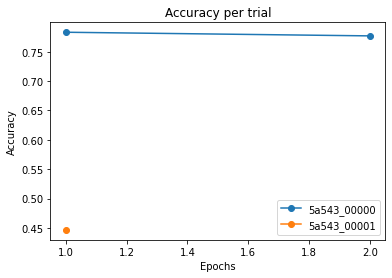

In [69]:
plot_trials(dfs)

Accuracy: 0.84361321


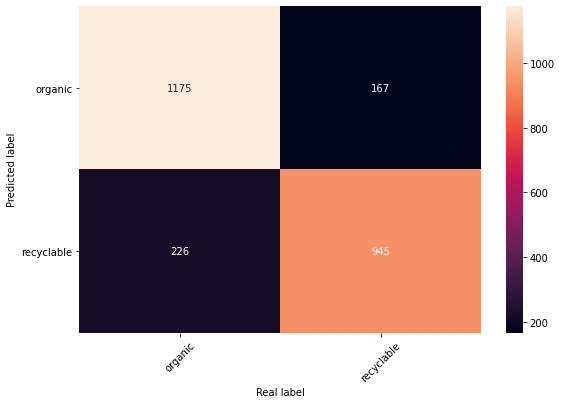

In [68]:
test_dataset = create_dataset(train=False)
test_loader = split_data(test_dataset, 
                        train=False, 
                        batch_size=32)

plot_confusion_matrix(best_trained_model, test_loader)

In [ ]:
file_name = "model_lr_0_00185_bs_32_opt_adam_wd_0_005"
save_model(best_trained_model, filename=file_name)
upload_model_to_drive(file_name)

In [ ]:
new_model = WasteClassifier()
file_name = "model_lr_0_00185_bs_32_opt_adam_wd_0_005"
load_model_from_drive(new_model, device, file_name)
new_model.to(device)

Accuracy: 0.84361321


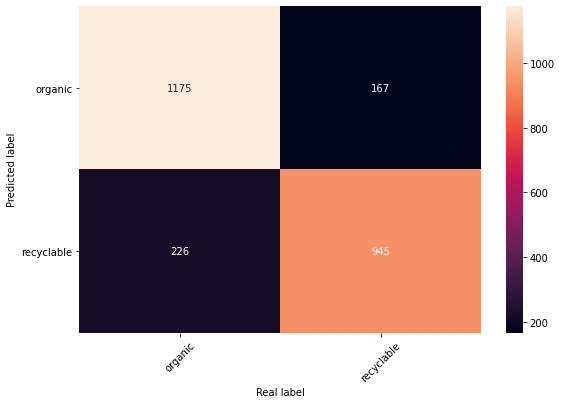

In [84]:
test_loader = split_data(test_dataset, 
                        train=False, 
                        batch_size=32)

plot_confusion_matrix(new_model, test_loader)

### Best Results so far  

Best trial config: {'lr': 0.0004852918273655538, 'batch_size': 32, 'optim': 'SGD', 'mm': 0.0, 'wd': 0}  
Best trial final validation loss: 0.46567279613524115  
Best trial final validation accuracy: 0.7880354505169868  
<br>
Best trial config: {'lr': 0.0018532418648827297, 'batch_size': 32, 'optim': 'ADAM', 'mm': 0.0, 'wd': 0.005}  
Best trial final validation loss: 0.4712947290742172  
Best trial final validation accuracy: 0.7769571639586411  